In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import statistics 
from PIL import Image
import glob

In [2]:
class Dataset():
    def __init__(self,path,batch_size):
        self.batch_size = batch_size
        self.get_data(path)
        self.reset()
    
    def reset(self):
        self.start = 0
        self.end = self.start + self.batch_size
        np.random.shuffle(self.files)
        
    def get_label(self, path):
        return tf.convert_to_tensor(np.array(path.strip().split('/')[-1].split('_')[0], dtype = np.int32))
    
    def get_image(self, path):
        return tf.convert_to_tensor(np.mean(np.array(Image.open(path)), axis = 2).reshape((80,80,1)), dtype=tf.float32)
    
    def get_data(self, path):
        self.files = np.array([f for f in glob.glob(path + '/*.jpg')])
        self.dataset_size = len(self.files)
        np.random.shuffle(self.files)
        
    def get_next_batch(self):
        if self.dataset_size <= self.start:
            self.reset()
            return None, None
        readings = self.files[self.start:self.end]

        imgs, labels = [], []
        for f in readings:
            imgs.append(self.get_image(f))
            labels.append(self.get_label(f))
        imgs = tf.stack(imgs, axis=0)
        labels = tf.stack(labels, axis=0)
        self.start = self.end
        self.end = self.start + self.batch_size
        if self.dataset_size <= self.end:
            self.end = self.dataset_size
        return imgs, labels

In [3]:
def conv2d(input, weight, bias, stride_size, pad = 'SAME', batchnorm = False):
    out = tf.nn.conv2d(input, weight, strides=[1, stride_size, stride_size, 1], padding=pad)
    out = tf.nn.bias_add(out,bias)
    
    if batchnorm == True:
        mean, var = tf.nn.moments(out, axes=[0,1,2], keepdims=False)
        out = tf.nn.batch_normalization(out, mean, var, offset = 0, scale = 1, variance_epsilon = 0.00001)
    
    return tf.nn.relu(out)

def maxpool(input, pool_size, stride_size, pad = 'VALID'):
    return tf.nn.max_pool2d(input, ksize=[1, pool_size, pool_size, 1], padding=pad, strides=[1, stride_size, stride_size, 1])

def dense(input, weight, bias, dropout_rate):
    x = tf.matmul(input, weight)
    x = tf.nn.bias_add(x, bias)
    
    if dropout_rate != 0:
        x = tf.nn.dropout(x, rate=dropout_rate)
        
    x = tf.nn.relu(x)
    return x

In [8]:
# Model specific functions, edit as you wish
def get_model_parameters(weight_shapes, bias_shapes, initializer_type = 'random'):
    def get_weight(shape, name, initializer):
        return tf.Variable(initializer(shape), name=name, trainable=True, dtype=tf.float32)
    
    if initializer_type == 'xavier':
        initializer = tf.initializers.glorot_uniform()
    else:
        initializer = tf.random_normal_initializer()

    weights = []
    for i in range(len(weight_shapes)):
        weights.append(get_weight(weight_shapes[i], 'weight{}'.format(i), initializer))
        
    biases = []
    for i in range(len(bias_shapes)):
        biases.append(get_weight(bias_shapes[i], 'bias{}'.format(i), initializer))
    return weights, biases

def loss_mae(model, input, labels, weights, biases, dropout_rate, weight_decay):
    out = model(input, weights, biases, dropout_rate)
    loss = tf.math.reduce_mean(tf.math.abs(tf.cast(labels, dtype = tf.float32) - out))
    return loss

def loss_min_mse_mae(model, input, labels, weights, biases, dropout_rate, weight_decay):
    out = model(input, weights, biases, dropout_rate)
    mse = tf.math.reduce_mean(tf.math.square(tf.cast(labels, dtype = tf.float32) - out))
    mae = tf.math.reduce_mean(tf.math.abs(tf.cast(labels, dtype = tf.float32) - out))
    loss = tf.math.minimum(mae, mse)
    return loss

def train_step_withloss(model, loss, optimizer, input, labels, weights, biases, dropout_rate, weight_decay):    
    with tf.GradientTape() as tape:
        current_loss = loss(model, input, labels, weights, biases, dropout_rate, weight_decay)
    dw, db = tape.gradient(current_loss, [weights, biases])
    optimizer.apply_gradients(zip(dw, weights))
    optimizer.apply_gradients(zip(db, biases))

def train_model_withloss(model1, weights1, biases1, loss1, train_ds, val_ds, optimizer1, lr1, num_epochs, dr1, wd1):
    cross_epoch_losses1 = []
    for e in range(num_epochs):
        idx = 1
        while True:
            x,y = train_ds.get_next_batch()

            if x != None:
                train_step_withloss(model1, loss1, optimizer1, x, y, weights1, biases1, dr1, wd1)
            else:
                break            
        val_losses1 = []
        while True:
            x,y = val_ds.get_next_batch()

            if x != None:
                val_losses1.append(loss_mae(model1, x, y, weights1, biases1, dr1, wd1).numpy())
            else:
                break
        
        crl1 = statistics.mean(val_losses1)
        cross_epoch_losses1.append(crl1)
        print('\nepoch {} - val_loss1: {:.3f}'.format(e + 1, crl1))
    plt.figure()
    plt.plot([e for e in range(num_epochs)], cross_epoch_losses1, 'r-', label='Model 1')
    plt.legend()
    plt.title('Validation error over epochs')
    plt.show()

In [5]:
def model3(x, weights, biases, dropout_rate): # batchnorm = True
    y = conv2d(x, weights[0], biases[0], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[1], biases[1], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[2], biases[2], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = conv2d(y, weights[3], biases[3], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)
    
    y = conv2d(y, weights[4], biases[4], stride_size=1, batchnorm = True)
    y = maxpool(y, pool_size=2, stride_size=2)

    y = tf.reshape(y, shape=(tf.shape(y)[0], -1))
    y = dense(y, weights[5], biases[5], dropout_rate = dropout_rate)
    y = dense(y, weights[6], biases[6], dropout_rate = dropout_rate)
    y = tf.matmul(y, weights[7]) + biases[7]
    return y


epoch 1 - val_loss1: 1.459

epoch 2 - val_loss1: 1.249

epoch 3 - val_loss1: 1.163

epoch 4 - val_loss1: 1.117

epoch 5 - val_loss1: 1.069

epoch 6 - val_loss1: 1.046

epoch 7 - val_loss1: 1.023

epoch 8 - val_loss1: 1.008

epoch 9 - val_loss1: 0.999

epoch 10 - val_loss1: 0.995


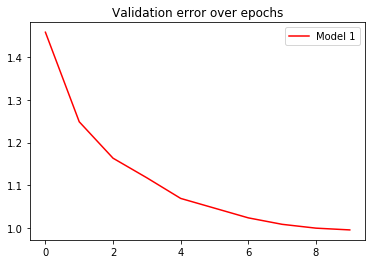

In [11]:
train_ds = Dataset('data/training/',1)
val_ds = Dataset('data/validation/',1)                                        
num_epochs = 10
lr = 0.000025
optimizer3 = tf.keras.optimizers.Adam(lr)
weights3, biases3 = get_model_parameters([
    [3, 3, 1, 4],
    [3, 3, 4, 16],
    [3, 3, 16, 16],
    [3, 3, 16, 64],
    [3, 3, 64, 64],
    [256, 32],
    [32, 4], 
    [4, 1],
], [
    [4,],
    [16,],
    [16,],
    [64,],
    [64,],
    [32,],
    [4,],
    [1,],
])
train_model_withloss(model3, weights3, biases3, loss_min_mse_mae, train_ds, val_ds, optimizer3, lr, num_epochs, 0, 0)

In [12]:
def test_model(model,weights,biases,test_ds):
    losses = []
    while True:
        x,y = test_ds.get_next_batch()
        if x != None:
            losses.append(loss_mae(model, x, y, weights, biases, 0, 0).numpy())
        else:
            break
    loss = statistics.mean(losses)
    print('test_loss: {:.3f}'.format(loss))
    
test_model(model3, weights3, biases3, Dataset('data/test/',1))

test_loss: 0.971
